# LangChain 1.0 Middleware – Taming the Overenthusiastic Agent

You know that feeling when you ask someone a simple question and they go on a 20-minute tangent? Agents can do the same thing. They'll happily loop forever, calling the model again and again, burning through your API budget like it's free pizza at a hackathon.

In this lesson, we'll watch an agent go a little overboard, then see how **ModelCallLimitMiddleware** puts a leash on it.

## 1. Setup

Same setup as the previous lesson. We'll use the MCP-powered LangChain docs tools so the agent has something meaty to research.

In [1]:
from dotenv import load_dotenv

load_dotenv()

import uuid
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain.agents import create_agent
from langchain.agents.middleware import ModelCallLimitMiddleware
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langchain.messages import HumanMessage
from helpers import draw_mermaid_png
from langchain_openai import ChatOpenAI

In [2]:
MCP_SERVERS = {
    "langchain-docs": {
        "transport": "streamable_http",
        "url": "https://docs.langchain.com/mcp/",
    }
}

mcp_client = MultiServerMCPClient(MCP_SERVERS)
LANGCHAIN_DOCS_TOOLS = await mcp_client.get_tools()

SYSTEM_PROMPT = """
You are a thorough research assistant answering questions about LangChain and LangGraph.
You have access to tools that query the official LangChain docs.

When asked to research a topic, be comprehensive. Search the docs multiple times if needed
to gather all relevant information. Don't stop after just one search.
"""

MODEL = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    model_kwargs={"parallel_tool_calls": False},
)

## 2. The Overenthusiastic Agent (No Limits)

First, let's build an agent with no guardrails. We'll give it a broad research task and count how many model calls it makes.

Here's the part that matters: the system prompt encourages thoroughness. The agent will keep searching and synthesizing until it feels done. Which might take a while.


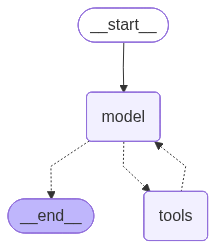

In [3]:
baseline_agent = create_agent(
    model=MODEL,
    tools=LANGCHAIN_DOCS_TOOLS,
    system_prompt=SYSTEM_PROMPT,
    checkpointer=InMemorySaver(),
)

draw_mermaid_png(baseline_agent)

Now let's give it something to chew on. A nice, broad research question.

In [4]:
RESEARCH_TASK = """
You are researching LangChain's built-in middleware.
Work in at least 5 clearly separated AI steps. After each step, send an answer
before continuing.

1. Step 1: Plan your research on built-in middleware (no tool calls yet). Output only the plan.
2. Step 2: Use the docs search tool to find a complete list of built-in middlewares. Output what you found.
3. Step 3: For each middleware in that list, run a separate docs search focused on that middleware and update your notes.
4. Step 4: Run another docs search focused only on limitations / failure modes / “gotchas” for these middlewares. Update your notes.
5. Step 5: Only after all previous steps, write the final consolidated answer for me.

At the end of each step, explicitly write: `STEP X DONE`, then continue with the next step.
"""

config = {"configurable": {"thread_id": str(uuid.uuid4())}}

response = await baseline_agent.ainvoke(
    {"messages": [HumanMessage(RESEARCH_TASK)]},
    config=config
)

# Count how many messages we ended up with
print(f"Total messages in conversation: {len(response['messages'])}")

Total messages in conversation: 12


In [5]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================


You are researching LangChain's built-in middleware.
Work in at least 5 clearly separated AI steps. After each step, send an answer
before continuing.

1. Step 1: Plan your research on built-in middleware (no tool calls yet). Output only the plan.
2. Step 2: Use the docs search tool to find a complete list of built-in middlewares. Output what you found.
3. Step 3: For each middleware in that list, run a separate docs search focused on that middleware and update your notes.
4. Step 4: Run another docs search focused only on limitations / failure modes / “gotchas” for these middlewares. Update your notes.
5. Step 5: Only after all previous steps, write the final consolidated answer for me.

At the end of each step, explicitly write: `STEP X DONE`, then continue with the next step.

================================== Ai Message ==================================

### Step 1: Plan your research on built-in m

Look at that message count. The agent went on quite a journey.

In a real app, this could mean:
- **Cost explosion** – each model call costs money
- **Latency nightmare** – users waiting forever
- **Infinite loops** – if something goes wrong, the agent might never stop

Time to put some boundaries in place.

## 3. Adding a Leash: ModelCallLimitMiddleware

The middleware is simple. You tell it the maximum number of model calls allowed, and it enforces that limit.

Two key parameters:
- `run_limit` – max calls for a single `.invoke()` 
- `exit_behavior` – what happens when the limit is hit: `"end"` (graceful stop) or `"error"` (raise an exception)

Let's cap our agent at 3 model calls and see what happens.


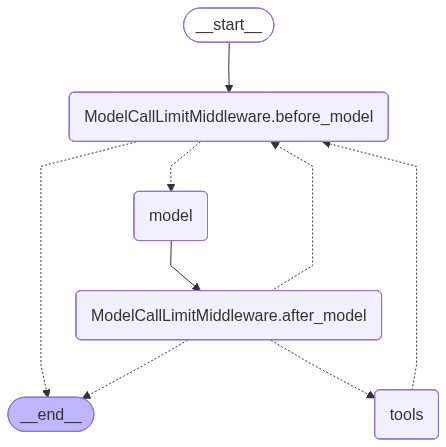

In [6]:
limited_agent = create_agent(
    model=MODEL,
    tools=LANGCHAIN_DOCS_TOOLS,
    system_prompt=SYSTEM_PROMPT,
    checkpointer=InMemorySaver(),
    middleware=[
        ModelCallLimitMiddleware(
            run_limit=3,
            exit_behavior="end",
        ),
    ],
)

draw_mermaid_png(limited_agent)

In [9]:
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

response = await limited_agent.ainvoke(
    {"messages": [HumanMessage(RESEARCH_TASK)]},
    config=config
)

print(f"Total messages in conversation: {len(response['messages'])}")

Total messages in conversation: 8


In [11]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================


You are researching LangChain's built-in middleware.
Work in at least 5 clearly separated AI steps. After each step, send an answer
before continuing.

1. Step 1: Plan your research on built-in middleware (no tool calls yet). Output only the plan.
2. Step 2: Use the docs search tool to find a complete list of built-in middlewares. Output what you found.
3. Step 3: For each middleware in that list, run a separate docs search focused on that middleware and update your notes.
4. Step 4: Run another docs search focused only on limitations / failure modes / “gotchas” for these middlewares. Update your notes.
5. Step 5: Only after all previous steps, write the final consolidated answer for me.

At the end of each step, explicitly write: `STEP X DONE`, then continue with the next step.

================================== Ai Message ==================================

### Step 1: Plan your research on built-in m

Notice the difference? The agent got cut off after 3 model calls.

With `exit_behavior="end"`, it stopped gracefully. The conversation just ends – no crash, no error, just a polite "that's enough for now."

The agent might not have finished its research, but at least your budget is intact.

## 4. When Would You Use This?

A few real-world scenarios:

- **Development & testing** – Cap calls low so you don't burn through credits while debugging
- **Cost control in production** – Set reasonable limits per request to prevent runaway costs
- **Safety net** – Even if your agent logic is solid, limits provide a backstop against unexpected loops

There's also `thread_limit` if you want to cap calls across an entire conversation thread (multiple invocations). But `run_limit` handles the most common case: keeping a single request from going off the rails.

## 5. The Takeaway

Agents are enthusiastic. Sometimes too enthusiastic.

`ModelCallLimitMiddleware` is a simple, one-line addition that gives you control over how much work an agent can do. It's not about making the agent worse – it's about making it predictable.

In production, predictability is worth its weight in gold. Or in this case, in API credits.

## Reference Links

**1. ModelCallLimitMiddleware – Python docs**

https://docs.langchain.com/oss/python/langchain/middleware/built-in

→ Full parameter reference including `thread_limit`, `run_limit`, and `exit_behavior`.

**2. Middleware in LangChain 1.0**

https://docs.langchain.com/oss/python/langchain/middleware

→ High-level guide to the middleware system and how to combine multiple middlewares.